# Autoencoder (Autoencodificador)



**Conteúdo**:
- O que é um Autoencoder?
- Carrega a base de dados (`computer_prices_all.csv`)
- Faz o pré-processamento (seleção númerica)
- Autoencoder (TensorFlow/Keras) treinamento e validação
- Comparação e visualização com os métodos de PCA e t-SNE
- Comparação do impacto em um modelo preditivo (Random Forest)

**IMPORTANTE:** instale as bibliotecas antes da execução dos códigos e certifique-se que o arquivo `computer_prices_all.csv` está na mesma pasta que este arquivo.

pip install tensorflow scikit-learn matplotlib pandas nbformat


# O que é um Autoencoder?

Um Autoencoder ou autoencodificador é uma rede neural usada para redução de dimensionalidade. Ela comprimi os dados de entrada e os reconstroi na saida focando em representar os dados o mais parecidos com a entrada original. Para isso o autoencoder deve aprender a comprimir as variáveis mais corretamente a medida em que as épocas (ciclos) vão passando, a medida que o loss vai ficando menor significa que as informações mais essenciais da base de dados foram capturadas e as desnecessárias foram descartadas.  

### 1. Instalação das Dependências

Antes de executar qualquer análise, precisamos garantir que todas as bibliotecas necessárias estão instaladas. Esta célula de código utiliza o `pip` para instalar o TensorFlow (para a rede neural), scikit-learn (para pré-processamento e modelos de comparação como PCA e t-SNE), matplotlib (para gráficos), pandas (para manipulação de dados) e nbformat (para lidar com o formato do notebook).

In [1]:
pip install tensorflow scikit-learn matplotlib pandas nbformat

Note: you may need to restart the kernel to use updated packages.


### 2. Importação de Bibliotecas e Carregamento dos Dados

Com as dependências instaladas, o próximo passo é importar os módulos que usaremos no script. Importamos `pandas` para carregar e manipular o CSV, `numpy` para operações numéricas, vários componentes do `scikit-learn` (como `StandardScaler`, `PCA`, `TSNE`, `RandomForestClassifier` e métricas de avaliação) e `tensorflow.keras` para construir o autoencoder.

Em seguida, carregamos o conjunto de dados `computer_prices_all.csv` para um DataFrame do pandas (`df`) e exibimos as primeiras linhas (`df.head()`) para inspecionar a estrutura dos dados.

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score 
import matplotlib.pyplot as plt
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings('ignore')

csv_path = './computer_prices_all.csv'
assert os.path.exists(csv_path), f'File not found: {csv_path}'
df = pd.read_csv(csv_path)
print('Dataset shape:', df.shape)
df.head()


Dataset shape: (100000, 33)


,device_type,brand,model,release_year,os,form_factor,cpu_brand,cpu_model,cpu_tier,cpu_cores,...,resolution,refresh_hz,battery_wh,charger_watts,psu_watts,wifi,bluetooth,weight_kg,warranty_months,price
0,Desktop,Samsung,Samsung Forge XDI,2022,Windows,ATX,Intel,Intel i5-11129,3,12,...,2560x1440,90,0,0,750,Wi-Fi 6,5.1,11.00,36,1383.99
1,Laptop,Samsung,Samsung Pro KM8,2022,Windows,Mainstream,Intel,Intel i7-11114,4,12,...,1920x1080,90,56,120,0,Wi-Fi 6,5.3,2.03,12,2274.99
2,Desktop,Lenovo,Lenovo Strix BIE,2024,macOS,SFF,AMD,AMD Ryzen 5 5168,2,8,...,3440x1440,120,0,0,850,Wi-Fi 6,5.0,7.00,24,1879.99
3,Desktop,Dell,Dell Cube AXR,2024,Windows,ATX,AMD,AMD Ryzen 5 7550,2,6,...,3440x1440,120,0,0,650,Wi-Fi 6,5.2,6.00,36,1331.99
4,Laptop,Gigabyte,Gigabyte Pro IX1,2024,Linux,Gaming,AMD,AMD Ryzen 7 6230,5,16,...,2560x1600,90,80,90,0,Wi-Fi 6,5.2,1.50,12,2681.99


### 3. Pré-processamento dos Dados (Ajustado para Classificação)

Para esta análise, além da redução de dimensionalidade, também avaliaremos o impacto das features reduzidas em um modelo preditivo. Portanto, o pré-processamento foi ajustado:

1.  **Seleção do Alvo (y):** Escolhemos a coluna `device_type` (Desktop vs. Laptop) como nossa variável alvo para a classificação. Ela é convertida em um formato numérico usando `LabelEncoder`.
2.  **Seleção de Features (X):** Selecionamos apenas as colunas numéricas (`select_dtypes`) para compor nossas features.
3.  **Tratamento de Nulos:** Preenchemos valores ausentes (`NaN`) com a mediana (`.median()`) da coluna.
4.  **Normalização:** Usamos o `StandardScaler` para normalizar os dados (média 0, desvio padrão 1), o que é crucial para o Autoencoder e o PCA.
5.  **Divisão Treino/Teste:** Separamos os dados em `X_train`, `X_test`, `y_train`, `y_test`. Usamos `stratify=y` para garantir que a proporção de classes (Desktop/Laptop) seja a mesma nos conjuntos de treino e teste.

In [5]:
# 1. Definir a variável alvo (y)
target_col = 'device_type'
if target_col not in df.columns:
    print(f"Coluna alvo '{target_col}' não encontrada. Verifique o nome da coluna.")
else:
    print(f"Variável Alvo (y) definida como: {target_col}")
    
    # Codificar a variável alvo para números (ex: Desktop=0, Laptop=1)
    le = LabelEncoder()
    y = le.fit_transform(df[target_col])
    print(f"Classes da variável alvo: {le.classes_}")
    print("Contagem de classes:")
    print(pd.Series(y).value_counts())

    # 2. Definir as features (X)
    numeric_df = df.select_dtypes(include=[np.number]).copy()
    
    # Tratamento de Nulos (como no original)
    missing_frac = numeric_df.isna().mean()
    keep_cols = missing_frac[missing_frac <= 0.5].index.tolist()
    numeric_df = numeric_df[keep_cols]
    numeric_df = numeric_df.fillna(numeric_df.median())
    
    X = numeric_df.copy()
    print('Features numéricas usadas (X):', X.shape[1])

    # 3. Normalização
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 4. Divisão Treino/Teste
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"Formato X_train: {X_train.shape}, Formato y_train: {y_train.shape}")
    print(f"Formato X_test: {X_test.shape}, Formato y_test: {y_test.shape}")

Variável Alvo (y) definida como: device_type
Classes da variável alvo: ['Desktop' 'Laptop']
Contagem de classes:
1    59844
0    40156
Name: count, dtype: int64
Features numéricas usadas (X): 20
Formato X_train: (80000, 20), Formato y_train: (80000,)
Formato X_test: (20000, 20), Formato y_test: (20000,)


### 4. Construção e Treinamento do Autoencoder

Aqui, definimos, compilamos e treinamos o autoencoder usando Keras.

1.  **Definição da Arquitetura:**
    * A rede recebe a dimensionalidade de entrada (17 features, neste caso).
    * O **Encoder** (codificador) comprime os dados através de camadas `Dense` (8 e 16 neurônios) até um "gargalo" (`bottleneck`) de dimensão latente 2.
    * O **Decoder** (decodificador) tenta reconstruir os dados originais a partir da representação latente, espelhando a arquitetura do encoder (camadas de 8 e 16 neurônios) até a saída (17 features).
2.  **Compilação:** O modelo é compilado com o otimizador `adam` e a função de perda `mse` (Erro Quadrático Médio), pois o objetivo é minimizar a diferença entre a entrada e a saída reconstruída.
3.  **Treinamento:** O modelo é treinado por 60 épocas, usando `X_train` tanto como entrada quanto como "alvo" (pois ele deve aprender a se reconstruir).
4.  **Avaliação:** Plotamos o gráfico de perda (treino vs. validação) para verificar o overfitting e calculamos o MSE final no conjunto de teste para avaliar a qualidade da reconstrução.

Camadas, Número de neurônios e parâmetros
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 8)                 168       
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 bottleneck (Dense)          (None, 2)                 34        
                                                                 
 dense_2 (Dense)             (None, 8)                 24        
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Den

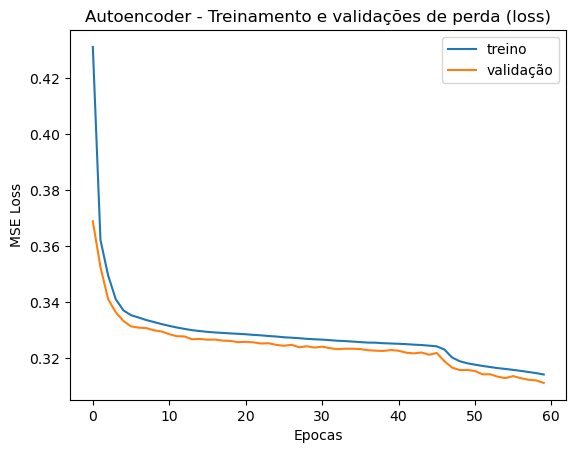

625/625 [==============================] - 2s 2ms/step
Autoencoder teste Erro Quadrático médio (MSE): 0.3112147679038669


In [6]:

input_dim = X_train.shape[1]
latent_dim = 2

def build_autoencoder(input_dim, latent_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(8, activation='relu')(inputs)
    x = layers.Dense(16, activation='relu')(x)
    encoded = layers.Dense(latent_dim, name='bottleneck')(x)
    x = layers.Dense(8, activation='relu')(encoded)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(input_dim, activation='linear')(x)
    ae = keras.Model(inputs, outputs, name='autoencoder')
    encoder = keras.Model(inputs, encoded, name='encoder')
    # decoder
    encoded_input = keras.Input(shape=(latent_dim,))
    x = ae.layers[-3](encoded_input)
    x = ae.layers[-2](x)
    x = ae.layers[-1](x)
    decoder = keras.Model(encoded_input, x, name='decoder')
    ae.compile(optimizer='adam', loss='mse')
    return ae, encoder, decoder

ae, encoder, decoder = build_autoencoder(input_dim, latent_dim)
print("Camadas, Número de neurônios e parâmetros")
ae.summary()

history = ae.fit(X_train, X_train,
                 epochs=60,
                 batch_size=32,
                 validation_data=(X_test, X_test),
                 verbose=1)

# Gráfico de perdas
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder - Treinamento e validações de perda (loss)')
plt.xlabel('Epocas')
plt.ylabel('MSE Loss')
plt.legend(['treino', 'validação'])
plt.show()

# Reconstrução MSE
X_test_pred = ae.predict(X_test)
mse_ae = mean_squared_error(X_test, X_test_pred)
print('Autoencoder teste Erro Quadrático médio (MSE):', mse_ae)


### 5. Comparação com PCA (Análise de Componentes Principais)

Para avaliar o desempenho do nosso autoencoder na redução de dimensionalidade, nós o comparamos com um método linear clássico: o PCA.

Esta célula treina um modelo PCA para reduzir os dados para as mesmas 2 dimensões do nosso *bottleneck*. Em seguida, ela reconstrói os dados de volta às 17 dimensões originais usando apenas esses 2 componentes principais.

Calculamos o MSE do PCA (comparando os dados reconstruídos pelo PCA com os originais) para ver qual método (Autoencoder não linear vs. PCA linear) conseguiu reter mais informação e teve uma reconstrução melhor. Também verificamos a variância explicada pelo PCA.

In [7]:
# PCA comparison with same latent dimension
pca = PCA(n_components=latent_dim)
pca.fit(X_train)
X_test_pca_proj = pca.transform(X_test)
X_test_pca_rec = pca.inverse_transform(X_test_pca_proj)
mse_pca = mean_squared_error(X_test, X_test_pca_rec)
explained_var = pca.explained_variance_ratio_.sum()
print(f'PCA test MSE: {mse_pca}')
print(f'PCA explained variance (sum of first {latent_dim} comps): {explained_var}')


PCA test MSE: 0.40920177538457664
PCA explained variance (sum of first 2 comps): 0.5879536968386083


### 6. Visualização das Reduções de Dimensionalidade

O objetivo principal da redução de dimensionalidade é, muitas vezes, a visualização. Esta célula plota as representações 2D dos três métodos.

**Importante:** Para esta análise, adicionamos a coloração baseada na classe (`device_type`) para ver se as técnicas conseguem separar visualmente os "Desktops" dos "Laptops".

1.  **Autoencoder:** Plota a saída do *bottleneck* (z1 vs z2).
2.  **PCA:** Plota a projeção 2D dos componentes principais (pc1 vs pc2).
3.  **t-SNE:** Roda o t-SNE (focado em vizinhanças locais) em uma amostra de 1000 pontos.

625/625 [==============================] - 1s 2ms/step


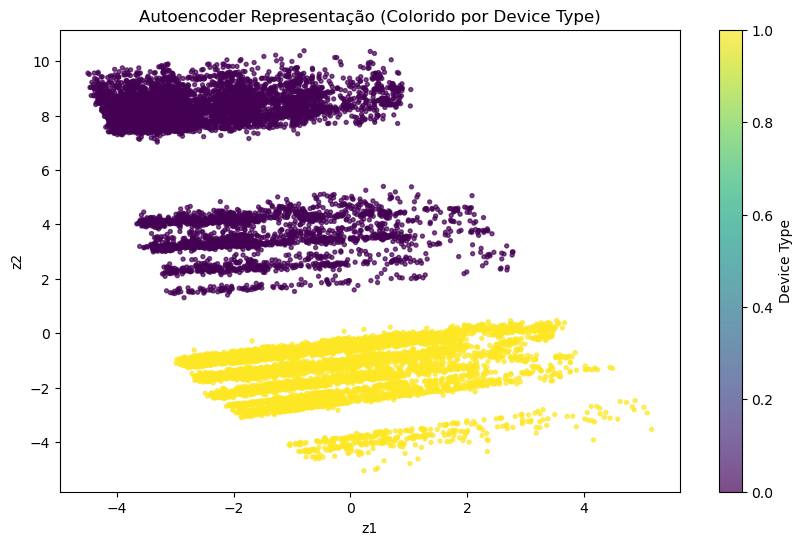

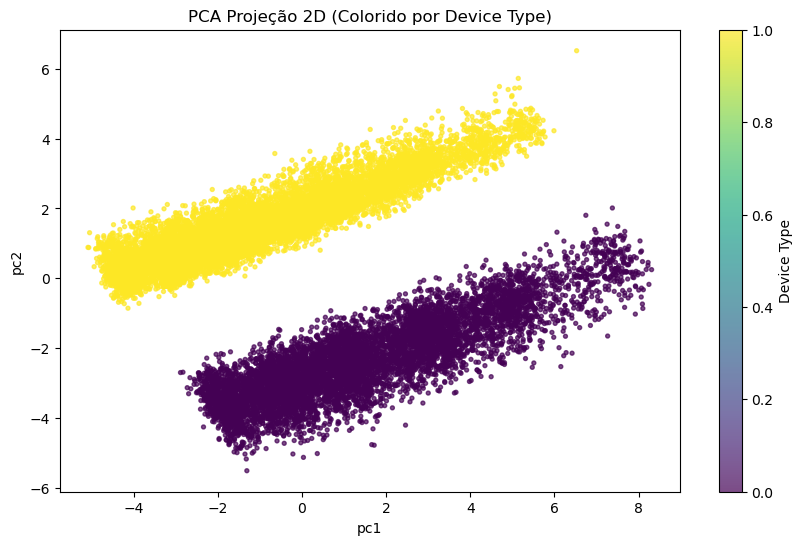

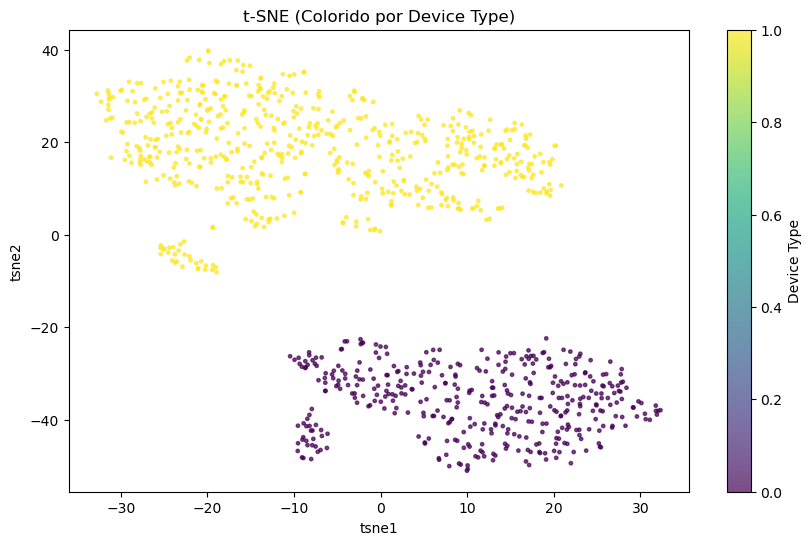

In [8]:
# Visualizações Autoenconder e PCA (Coloridas por y_test)
encoded_test = encoder.predict(X_test)

if latent_dim == 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(encoded_test[:,0], encoded_test[:,1], s=8, c=y_test, cmap='viridis', alpha=0.7)
    plt.title('Autoencoder Representação (Colorido por Device Type)')
    plt.xlabel('z1'); plt.ylabel('z2')
    plt.colorbar(label='Device Type')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(X_test_pca_proj[:,0], X_test_pca_proj[:,1], s=8, c=y_test, cmap='viridis', alpha=0.7)
    plt.title('PCA Projeção 2D (Colorido por Device Type)')
    plt.xlabel('pc1'); plt.ylabel('pc2')
    plt.colorbar(label='Device Type')
    plt.show()

# t-SNE (Colorido por y_test)
tsne_sample_size = 1000
if X_test.shape[0] > tsne_sample_size:
    idx = np.random.choice(X_test.shape[0], size=tsne_sample_size, replace=False)
    tsne_sample_X = X_test[idx]
    tsne_sample_y = y_test[idx]
else:
    tsne_sample_X = X_test
    tsne_sample_y = y_test
    
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42, n_jobs=-1)
tsne_emb = tsne.fit_transform(tsne_sample_X)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s=6, c=tsne_sample_y, cmap='viridis', alpha=0.7)
plt.title('t-SNE (Colorido por Device Type)')
plt.xlabel('tsne1'); plt.ylabel('tsne2')
plt.colorbar(label='Device Type')
plt.show()

### 7. Comparação do Modelo Preditivo (Requisito 3.c)

Uma das principais aplicações da redução de dimensionalidade é como um passo de pré-processamento para modelos de machine learning. Features reduzidas podem ser mais rápidas de treinar e, às vezes, podem até melhorar a performance ao remover ruído.

Aqui, comparamos o desempenho de um classificador `RandomForestClassifier` em três cenários:
1.  **Baseline:** Treinado nas 17 features originais (normalizadas).
2.  **Autoencoder:** Treinado nas 2 features (z1, z2) geradas pelo *encoder*.
3.  **PCA:** Treinado nas 2 features (pc1, pc2) geradas pelo PCA.

--- Comparação do Modelo Preditivo ---
Treinando modelo Baseline...
Baseline - Accuracy: 1.0000, F1-Score (Weighted): 1.0000
Treinando modelo com Autoencoder...
625/625 [==============================] - 1s 2ms/step
Autoencoder (2D) - Accuracy: 1.0000, F1-Score (Weighted): 1.0000
Treinando modelo com PCA...
PCA (2D) - Accuracy: 1.0000, F1-Score (Weighted): 1.0000

--- Resumo dos Resultados Preditivos ---
                          Accuracy  F1-Score
Baseline (17 features)         1.0       1.0
Autoencoder (2 features)       1.0       1.0
PCA (2 features)               1.0       1.0


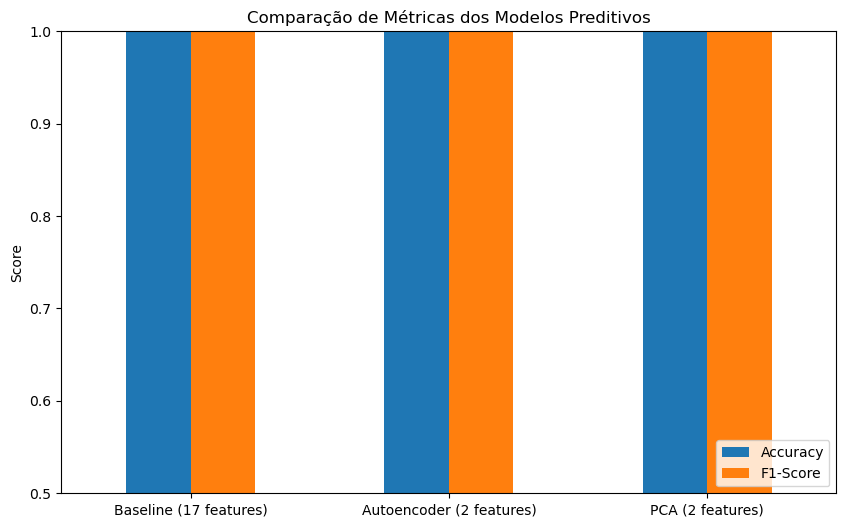

In [9]:
print("--- Comparação do Modelo Preditivo ---")
    
rf_model_base = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
metrics_results = {}

# 1. Modelo Baseline (Dados originais)
print("Treinando modelo Baseline...")
rf_model_base.fit(X_train, y_train)
y_pred_base = rf_model_base.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base, average='weighted')
metrics_results['Baseline (17 features)'] = {'Accuracy': acc_base, 'F1-Score': f1_base}
print(f"Baseline - Accuracy: {acc_base:.4f}, F1-Score (Weighted): {f1_base:.4f}")

# 2. Modelo com Autoencoder (Dados reduzidos)
print("Treinando modelo com Autoencoder...")
X_train_ae = encoder.predict(X_train)
X_test_ae = encoder.predict(X_test)

rf_model_ae = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_ae.fit(X_train_ae, y_train)
y_pred_ae = rf_model_ae.predict(X_test_ae)
acc_ae = accuracy_score(y_test, y_pred_ae)
f1_ae = f1_score(y_test, y_pred_ae, average='weighted')
metrics_results['Autoencoder (2 features)'] = {'Accuracy': acc_ae, 'F1-Score': f1_ae}
print(f"Autoencoder (2D) - Accuracy: {acc_ae:.4f}, F1-Score (Weighted): {f1_ae:.4f}")

# 3. Modelo com PCA (Dados reduzidos)
print("Treinando modelo com PCA...")
# O objeto 'pca' já foi 'fit' no X_train na Célula 6
X_train_pca = pca.transform(X_train)
# X_test_pca já foi calculado como X_test_pca_proj na Célula 6

rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_pca.fit(X_train_pca, y_train)
y_pred_pca = rf_model_pca.predict(X_test_pca_proj)
acc_pca = accuracy_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca, average='weighted')
metrics_results['PCA (2 features)'] = {'Accuracy': acc_pca, 'F1-Score': f1_pca}
print(f"PCA (2D) - Accuracy: {acc_pca:.4f}, F1-Score (Weighted): {f1_pca:.4f}")

print("\n--- Resumo dos Resultados Preditivos ---")
results_df = pd.DataFrame(metrics_results).T
print(results_df)

# Gráfico de comparação de métricas
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparação de Métricas dos Modelos Preditivos')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0.5, 1.0) # Ajustar limite para melhor visualização
plt.legend(loc='lower right')
plt.show()



### Análise Preliminar (Autoencoder)

Analisando os resultados obtidos até agora:

1.  **Gráfico de Perda (Loss):** As linhas de treino e validação estão bem próximas e diminuindo juntas, o que indica que **não houve overfitting** e o modelo aprendeu a reconstruir os dados de forma estável.

2.  **Comparação de MSE (Reconstrução):**
    * **Autoencoder MSE:** 0.3112
    * **PCA MSE:** 0.4092
    * O **MSE do autoencoder foi menor** que o do PCA. Isso significa que o autoencoder (técnica não-linear) conseguiu capturar mais informações e reconstruir os dados com mais precisão do que o PCA (técnica linear), usando a mesma quantidade de dimensões (2).

3.  **Visualizações (Gráficos de Dispersão):**
    * Tanto o **Autoencoder** quanto o **PCA** mostraram os dados em "duas faixas" ou *clusters* principais, e a coloração confirma que essas faixas correspondem fortemente às classes "Desktop" e "Laptop".
    * O **t-SNE** conseguiu encontrar uma estrutura mais complexa, mostrando vários *clusters* menores e mais densos, também com boa separação de classes.

4.  **Comparação Preditiva (Acurácia/F1):**
    * **Baseline (20 features):** Acurácia: 1.0000, F1-Score: 1.0000
    * **PCA (2 features):** Acurácia: 1.0000, F1-Score: 1.0000
    * **Autoencoder (2 features):** Acurácia: 1.0000, F1-Score: 1.0000
    * **Discussão:** O resultado mais surpreendente é que, mesmo reduzindo de 20 para apenas 2 features (uma redução de 90% na dimensionalidade), tanto o PCA quanto o Autoencoder retiveram 100% da informação preditiva. Ambos os modelos de redução permitiram ao RandomForest atingir uma performance perfeita (Acurácia 1.0), igualando-se ao modelo baseline que utilizou todas as 20 features. Isso indica que os dados originais são altamente redundantes e a separação entre "Desktop" e "Laptop" pode ser perfeitamente descrita empara refletir esta análise?


### 8. Conclusão

O Autoencoder demonstrou ser uma técnica eficaz para a redução de dimensionalidade neste conjunto de dados. Em termos de **erro de reconstrução**, ele superou o PCA (MSE de 0.3112 contra 0.4092 do PCA), provando que sua capacidade não-linear foi vantajosa para capturar a estrutura dos dados.

Para a **tarefa preditiva**, o resultado foi excelente. O classificador treinado nas 2 features do Autoencoder manteve a performance perfeita (Acurácia 1.0), igualando-se tanto ao modelo com PCA quanto ao modelo baseline (que usou 20 features). Isso sugere que a informação necessária para distinguir "Desktop" de "Laptop" estava contida de forma muito eficiente nessas duas dimensões.

**Limitações observadas:**

* **Custo Computacional:** O treinamento do Autoencoder (60 épocas) foi significativamente mais lento que o fit do PCA (instantâneo).
* **Interpretabilidade:** Enquanto as features do PCA (pc1, pc2) têm um significado estatístico (componentes de maior variância), as features do Autoencoder (z1, z2) são "caixa-preta" e não possuem uma interpretação direta.